In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load dataset
brain_cancer_df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/BrainCancerData.xlsx")

# Inspect the data quickly
print(brain_cancer_df.head())
print(brain_cancer_df.info())
print(brain_cancer_df.describe())

# Check for missing values
print("Missing Values:\n", brain_cancer_df.isnull().sum())

# Drop unnecessary columns (like "No.")
brain_cancer_df = brain_cancer_df.drop(columns=["No."])

# Separate features and labels
X = brain_cancer_df.drop(columns=["class label"])
y = brain_cancer_df["class label"]

# Encode labels to numerical format
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Feature Scaling (Standardization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Save preprocessed datasets clearly to CSV files
pd.DataFrame(X_train).to_csv("brain_cancer_X_train.csv", index=False)
pd.DataFrame(X_test).to_csv("brain_cancer_X_test.csv", index=False)
pd.DataFrame(y_train, columns=["Cancer_Type"]).to_csv("brain_cancer_y_train.csv", index=False)
pd.DataFrame(y_test, columns=["Cancer_Type"]).to_csv("brain_cancer_y_test.csv", index=False)

print(" Brain Cancer dataset preprocessing completed and saved successfully!")


   No.        v1        v2        v3        v4        v5        v6        v7  \
0    1  2.938354  3.138208  3.300422  3.221013  3.814756  4.494703  3.427234   
1    2  2.491011  1.510817  1.658108  2.302325  2.875599  1.575391  2.244480   
2    3  3.644503  2.845455  4.309304  4.166156  4.056208  3.683680  3.085278   
3    4  1.860832  3.873751  1.086140  1.725553  1.833238  3.357366  3.546659   
4    5  2.563717  1.412766  2.401923  3.063189  3.289470  2.703286  2.807458   

         v8        v9  ...     v1492     v1493     v1494     v1495     v1496  \
0  2.044687  2.745238  ...  0.243287  1.003977 -0.518222 -1.472913 -0.239216   
1  2.614274  3.151004  ... -0.981711 -1.225290 -0.125534 -0.705315  0.116246   
2  3.315754  3.487620  ...  0.073161 -0.610658  0.127932 -0.331715  0.793684   
3  3.761367  3.919646  ... -0.012919  0.512803 -0.523655 -0.463826  0.519912   
4  3.678409  2.666864  ... -0.979546  0.587593 -2.058093 -0.224098  0.490356   

      v1497     v1498     v1499     v1

Using device: cuda
BrainCancerMLP(
  (model): Sequential(
    (0): Linear(in_features=1500, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=4, bias=True)
  )
)
Epoch 1/100 - Train Loss: 1.0224, Train Acc: 0.6268 - Val Loss: 0.6461, Val Acc: 0.7857
Epoch 2/100 - Train Loss: 0.7674, Train Acc: 0.7393 - Val Loss: 0.5901, Val Acc: 0.7929
Epoch 3/100 - Train Loss: 0.6769, Train Acc: 0.7482 - Val Loss: 0.5081, Val Ac

<ipython-input-5-2fd7a6825d02>:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_brain_cancer_mlp_model.pth"))


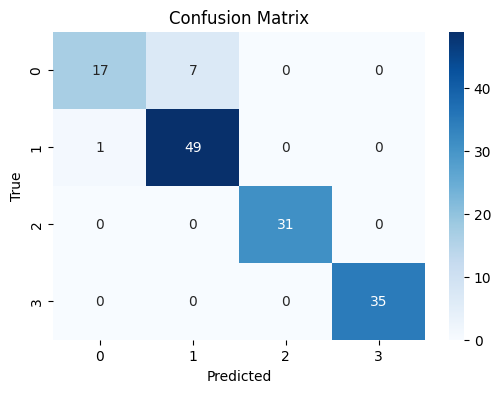

Brain Cancer Classification Results Saved!


In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 1. Load preprocessed CSV files
X_train = pd.read_csv("brain_cancer_X_train.csv").values  # features
X_test = pd.read_csv("brain_cancer_X_test.csv").values
y_train = pd.read_csv("brain_cancer_y_train.csv")["Cancer_Type"].values  # labels
y_test = pd.read_csv("brain_cancer_y_test.csv")["Cancer_Type"].values

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 2. Define the MLP model for classification
class BrainCancerMLP(nn.Module):
    def __init__(self, input_dim, num_classes=4):
        super(BrainCancerMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.model(x)

input_dim = X_train.shape[1]
model = BrainCancerMLP(input_dim=input_dim, num_classes=4).to(device)
print(model)

# 3. Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. Training loop
num_epochs = 100
best_val_loss = np.inf
patience = 10
trigger_times = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total

    # Validation step
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = val_loss / total_val
    val_acc = correct_val / total_val

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        # Optionally, save the best model
        torch.save(model.state_dict(), "best_brain_cancer_mlp_model.pth")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered!")
            break

# 5. Evaluation on test set
model.load_state_dict(torch.load("best_brain_cancer_mlp_model.pth"))
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds))

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# Save Brain Cancer classification results
brain_predictions = pd.DataFrame({"Predicted_Label": all_preds})
brain_predictions.to_csv("brain_cancer_classification_results.csv", index=False)
print("Brain Cancer Classification Results Saved!")

